In [1]:
import numpy as np
from scipy.optimize import fsolve
from scipy.signal import convolve2d
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
def func(x, a, b):
    return [a - x[0] - (4*x[0]*x[1])/(1 + x[0]**2), b*x[0] * (1 - x[1]/(1+x[0]**2))]

def get_fixed_point(a, b):
    solution = fsolve(func, [0, 0], args=(a, b))
    if np.all(solution == [0 ,0]):
        return np.array([np.nan, np.nan])
    else:
        return solution

def get_jacobian(x, y, a, b):
    j11 = -1 - (4*y / (1+x**2)) + ((8*y*x**2) / ((1+x**2)**2))
    j12 = -4*x / (1+x**2)
    j21 = b - (b*y / (1+x**2)) + (2*b*y*x**2 / (1+x**2)**2)
    j22 = -b*x / (1+x**2)
    return np.array([[j11, j12], [j21, j22]])

def get_stability(j):
    tr = np.trace(j)
    det = np.linalg.det(j)
    is_spiral = 4*det > tr
    is_stable = tr < 0 and det > 0
    return is_spiral, is_stable

C:\Users\LW\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\linalg\_linalg.py:2383: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\LW\AppData\Local\Temp\ipykernel_49460\3969900200.py:5: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(func, [0, 0], args=(a, b))


Text(0.5, 1.0, 'stability on a,b plane')

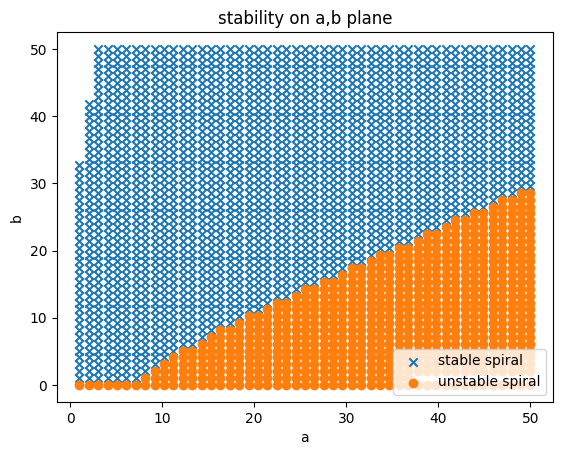

In [3]:
a_vec = np.linspace(0, 50, 50)
b_vec = np.linspace(0, 50, 50)
roots = np.zeros([a_vec.size, b_vec.size, 2])
spirals = np.zeros([a_vec.size, b_vec.size]).astype(bool)
stability = np.zeros([a_vec.size, b_vec.size]).astype(bool)
for i, a in enumerate(a_vec):
    for j, b in enumerate(b_vec):
        root = get_fixed_point(a, b)
        roots[i, j, :] = root
        jacobian = get_jacobian(root[0], root[1], a, b)
        spirals[i, j], stability[i, j] = get_stability(jacobian)

fig, ax = plt.subplots()
stable_spirals = np.logical_and(spirals, stability)
stable_spiral_points = np.where(stable_spirals)
ax.scatter(a_vec[stable_spiral_points[0]], b_vec[stable_spiral_points[1]], marker='x', label='stable spiral')

unstable_spirals = np.logical_and(spirals, ~stability)
unstable_spiral_points = np.where(unstable_spirals)
ax.scatter(a_vec[unstable_spiral_points[0]], b_vec[unstable_spiral_points[1]], marker='o', label='unstable spiral')

ax.legend()
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_title('stability on a,b plane')

Text(0.5, 1.0, 'Hopf bifurcation points')

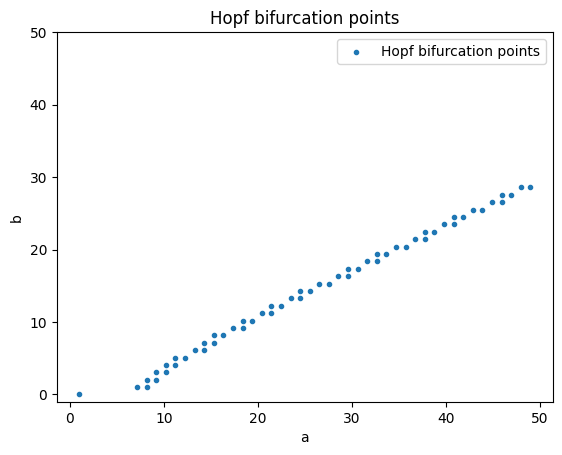

In [4]:
spiral_points = stable_spirals.astype(int) - unstable_spirals.astype(int)
edge_detection_kernel = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
])
edges = convolve2d(spiral_points, edge_detection_kernel, mode='same')
edge_points = np.where(np.abs(edges) > 3)

fig, ax = plt.subplots()
ax.scatter(a_vec[edge_points[0]], b_vec[edge_points[1]], marker='.', label='Hopf bifurcation points')
ax.legend()
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_ylim([-1, 50])
ax.set_title('Hopf bifurcation points')

In [14]:
def get_nullcline(x, a, b):
    return [(x-a) * (1+x**2) / (-4*x), 1 + x**2]

def explicit_func(t, x, a, b):
    return [a - x[0] - (4*x[0]*x[1])/(1 + x[0]**2), b*x[0] * (1 - x[1]/(1+x[0]**2))]

def get_trajectories(a, b, x):
    trajectory = solve_ivp(explicit_func, [0, 100], x, args=(a, b))
    return trajectory.y

def get_vector_field(a, b):
    x_grid = np.linspace(-50, 50, 200)
    y_grid = np.linspace(-200, 200, 400)
    X, Y = np.meshgrid(x_points, y_points)
    Dx = func([X, Y], a, b)
    return Dx, x_grid, y_grid

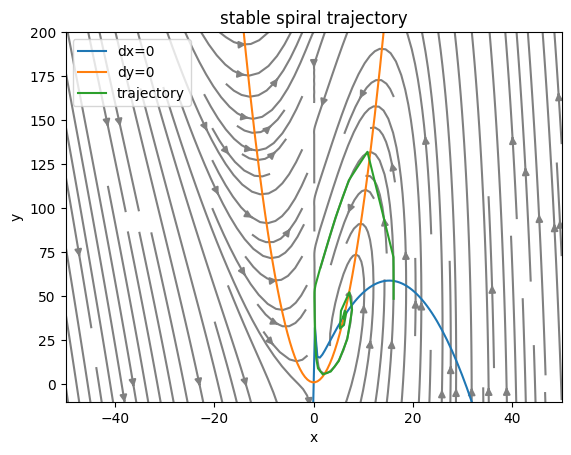

In [26]:
### stable spiral
x_points = np.linspace(-50, 50, 200)
a_index = 30
b_index = 30
nullclines = get_nullcline(x_points, a_vec[a_index], b_vec[b_index])
trajectory = get_trajectories(a_vec[a_index], b_vec[b_index], roots[a_index, b_index]+10)
Dx, x_grid, y_grid = get_vector_field(a_vec[a_index], b_vec[b_index])

fig, ax = plt.subplots()
ax.streamplot(x_points, y_points, Dx[0], Dx[1], color='gray', density=1.5)
ax.plot(x_points, nullclines[0], label='dx=0')
ax.plot(x_points, nullclines[1], label='dy=0')
ax.plot(trajectory[0], trajectory[1], label='trajectory')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('stable spiral trajectory')
ax.set_ylim([-10, 200])
ax.legend()

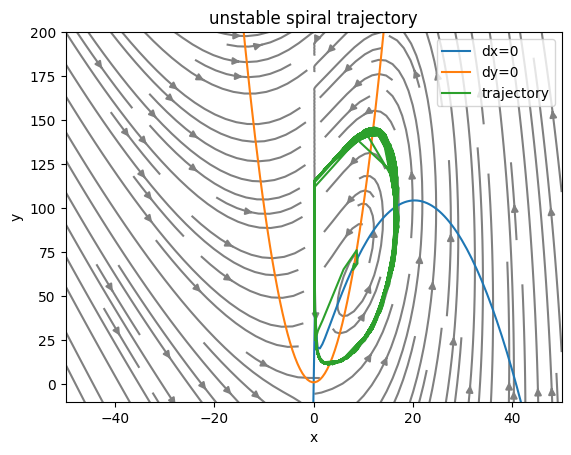

In [25]:
### unstable spiral
x_points = np.linspace(-50, 50, 200)
a_index = 40
b_index = 10
nullclines = get_nullcline(x_points, a_vec[a_index], b_vec[b_index])
trajectory = get_trajectories(a_vec[a_index], b_vec[b_index], roots[a_index, b_index]+0.001)
Dx, x_grid, y_grid = get_vector_field(a_vec[a_index], b_vec[b_index])

fig, ax = plt.subplots()
ax.streamplot(x_points, y_points, Dx[0], Dx[1], color='gray', density=1.5)
ax.plot(x_points, nullclines[0], label='dx=0')
ax.plot(x_points, nullclines[1], label='dy=0')
ax.plot(trajectory[0], trajectory[1], label='trajectory')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('unstable spiral trajectory')
ax.set_ylim([-10, 200])
ax.legend()

In [8]:
def get_vector_field(a, b):
    x_points = np.linspace(-200, 200, 400)
    y_points = np.linspace(-200, 200, 400)
    X, Y = np.meshgrid(x_points, y_points)
    Dx = func([X, Y], a, b)
    return Dx, x_points, y_points


Text(0.5, 1.0, 'stable spiral trajectory')

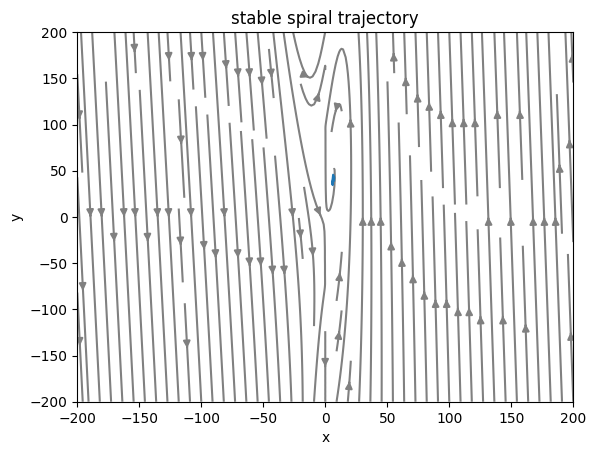

In [9]:
### stable spiral
a_index = 30
b_index = 30

Dx, x_points, y_points = get_vector_field(a_vec[a_index], b_vec[b_index])
trajectory = get_trajectories(a_vec[a_index], b_vec[b_index], roots[a_index, b_index]+1)


fig, ax = plt.subplots()
ax.streamplot(x_points, y_points, Dx[0], Dx[1], color='gray', density=1.5)
ax.plot(trajectory[0], trajectory[1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('stable spiral trajectory')

Text(0.5, 1.0, 'unstable spiral trajectory')

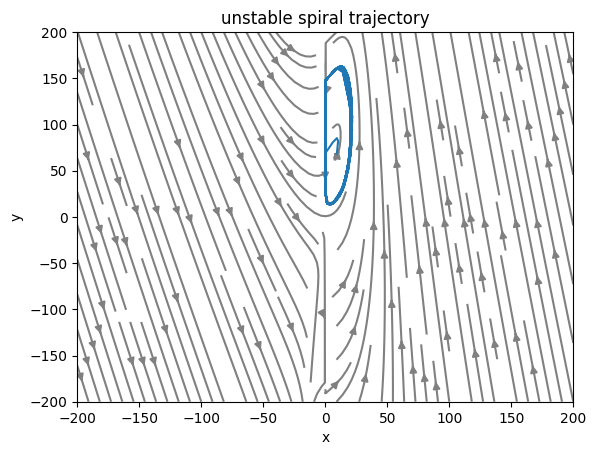

In [10]:
### unstable spiral
a_index = 40
b_index = 5

Dx, x_points, y_points = get_vector_field(a_vec[a_index], b_vec[b_index])
trajectory = get_trajectories(a_vec[a_index], b_vec[b_index], roots[a_index, b_index]+1)


fig, ax = plt.subplots()
ax.streamplot(x_points, y_points, Dx[0], Dx[1], color='gray', density=1.5)
ax.plot(trajectory[0], trajectory[1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('unstable spiral trajectory')